In [ ]:
# Matthew Alfredo
# matthewwalfredoo@gmail.com
# matthewalfredoo

In [ ]:
# classification two kinds of eye diseases.
# There will be only 4 classes where eyes are either Normal (N), Cataract (C), Hypertension (H), Pathological Myopia (M)

## Preparation

Setting up everything including the Google Colab environment to be able to use kaggle command, downloading the dataset, and downloading the custom CSV files we have put in a GitHub repository.

In [169]:
from google.colab import files
# files.upload() # upload kaggle.json file here

# download the kaggle.json file instead of uploading them from local file
!wget --no-check-certificate \
  https://raw.githubusercontent.com/matthewalfredoo/Project-Introdcution-to-ML/main/kaggle.json \
  -O /content/kaggle.json

!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

--2022-11-08 13:57:10--  https://raw.githubusercontent.com/matthewalfredoo/Project-Introdcution-to-ML/main/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70 [text/plain]
Saving to: ‘/content/kaggle.json’

/content/kaggle.jso 100%[===================>]      70  --.-KB/s    in 0s      

2022-11-08 13:57:11 (4.49 MB/s) - ‘/content/kaggle.json’ saved [70/70]

-rw-r--r-- 1 root root 70 Nov  8 13:57 kaggle.json


In [170]:
!pwd

/content


In [171]:
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

ocular-disease-recognition-odir5k.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip ocular-disease-recognition-odir5k.zip

Streaming output truncated to the last 5000 lines.
  inflating: preprocessed_images/2179_left.jpg  
  inflating: preprocessed_images/2179_right.jpg  
  inflating: preprocessed_images/217_left.jpg  
  inflating: preprocessed_images/217_right.jpg  
  inflating: preprocessed_images/2180_left.jpg  
  inflating: preprocessed_images/2180_right.jpg  
  inflating: preprocessed_images/2181_left.jpg  
  inflating: preprocessed_images/2181_right.jpg  
  inflating: preprocessed_images/2182_left.jpg  
  inflating: preprocessed_images/2182_right.jpg  
  inflating: preprocessed_images/2183_left.jpg  
  inflating: preprocessed_images/2183_right.jpg  
  inflating: preprocessed_images/2184_left.jpg  
  inflating: preprocessed_images/2184_right.jpg  
  inflating: preprocessed_images/2185_left.jpg  
  inflating: preprocessed_images/2185_right.jpg  
  inflating: preprocessed_images/2187_left.jpg  
  inflating: preprocessed_images/2187_right.jpg  
  inflating: preprocessed_images/2189_left.jpg  
  inflating

In [9]:
# download the dataset
!wget --no-check-certificate \
  https://raw.githubusercontent.com/matthewalfredoo/Project-Introdcution-to-ML/main/full_df_4_classes.csv \
  -O /content/full_df_4_classes.csv

--2022-11-08 11:24:15--  https://raw.githubusercontent.com/matthewalfredoo/Project-Introdcution-to-ML/main/full_df_4_classes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 780257 (762K) [text/plain]
Saving to: ‘/content/full_df_4_classes.csv’

/content/full_df_4_ 100%[===================>] 761.97K  --.-KB/s    in 0.006s  

2022-11-08 11:24:16 (115 MB/s) - ‘/content/full_df_4_classes.csv’ saved [780257/780257]



## Loading and Preprocessing Data

In this section, data will be loaded using ```pandas``` and there will be some preprocessing data. Some brief information about the dataset will also be shown here.

In [87]:
import pandas as pd

# reading the dataset as a dataframe using pandas
df = pd.read_csv('full_df_4_classes.csv')
df.head() 

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",8_right.jpg
3,10,70,Male,10_left.jpg,10_right.jpg,epiretinal membrane,normal fundus,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",10_right.jpg
4,13,60,Female,13_left.jpg,13_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",13_right.jpg


In [121]:
# removes features that are not needed 
df_cut = df.drop(df.columns[list(range(5, 16)) + list(range(3, 5)) + list(range(17, 18))], axis=1)
df_cut = df_cut.drop(columns=['ID'])
df_cut.head()

,Patient Age,Patient Sex,labels,filename
0,69,Female,['N'],0_right.jpg
1,57,Male,['N'],1_right.jpg
2,59,Male,['N'],8_right.jpg
3,70,Male,['N'],10_right.jpg
4,60,Female,['M'],13_right.jpg


In [122]:
# transforming labels to plain string
# before transformed it looked like this ['M']
# after transformed it looks like this M

string_labels = []
for label in df_cut.labels:
  if(len(label) == 5):
    string_labels.append(label[2])
  else:
    print(label)

In [123]:
# changes the labels column with newly transformed labels from cell above

df_cut = df_cut.drop(columns=['labels'])
df_cut = pd.concat([df_cut, pd.DataFrame(string_labels, columns = ['Labels'])], axis=1)

df_cut.head()

,Patient Age,Patient Sex,filename,Labels
0,69,Female,0_right.jpg,N
1,57,Male,1_right.jpg,N
2,59,Male,8_right.jpg,N
3,70,Male,10_right.jpg,N
4,60,Female,13_right.jpg,M


In [124]:
# show number of each classes' images
labels_list = df_cut.Labels.tolist()
print('Total class Normal images:', labels_list.count('N'))
print('Total class Cataract images:', labels_list.count('C'))
print('Total class Hypertension images:', labels_list.count('H'))
print('Total class Pathological Myopia:', labels_list.count('M'))

Total class Normal images: 2873
Total class Cataract images: 293
Total class Hypertension images: 128
Total class Pathological Myopia: 232


In [125]:
# delete 2573 rows of class Normal, since class Normal images are way too high
# compared to other classes

target_deleted = 2573
data_deleted = 0  # this should reach the number 2573

for i in range(0, len(df_cut)):
  if data_deleted == target_deleted:
    break
  
  if df_cut.Labels[i] == 'N':
    df_cut = df_cut.drop(i)
    data_deleted += 1

# reset the indexing of the dataframe
df_cut = df_cut.reset_index(drop=True)
df_cut.head()

,Patient Age,Patient Sex,filename,Labels
0,60,Female,13_right.jpg,M
1,54,Female,16_right.jpg,M
2,58,Male,18_right.jpg,M
3,47,Male,23_right.jpg,H
4,75,Female,24_right.jpg,C


In [126]:
# show number of each classes' images
labels_list = df_cut.Labels.tolist()
print('Total class Normal images:', labels_list.count('N'))
print('Total class Cataract images:', labels_list.count('C'))
print('Total class Hypertension images:', labels_list.count('H'))
print('Total class Pathological Myopia:', labels_list.count('M'))

Total class Normal images: 300
Total class Cataract images: 293
Total class Hypertension images: 128
Total class Pathological Myopia: 232


In [127]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

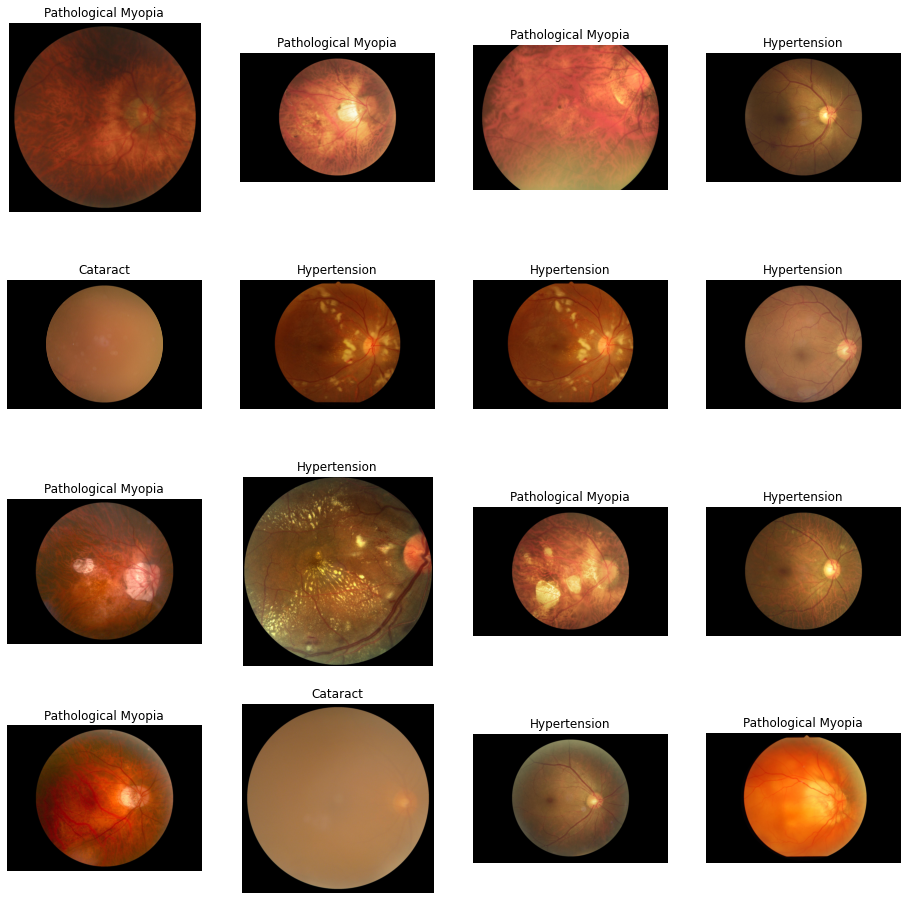

In [179]:
import os

# setup matplotlib fig, and size it to fit 4 x 4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

filename_list = df_cut.filename.tolist()

i = 0
for index_image in range(0, len(filename_list)):
  # if 4 x 4 pics are already there, stop the loop
  if i == 16:
    break
  
  # setup subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # don't show axes (or gridlines)
  
  # reading and showing the image
  img = mpimg.imread(os.path.join('/content/ODIR-5K/ODIR-5K/Training Images/', filename_list[index_image]))
  plt.imshow(img)
  
  # putting title on top of the image
  title = df_cut.Labels[index_image]
  if title == 'N':
    title = 'Normal'
  elif title == 'H':
    title = 'Hypertension'
  elif title == 'C':
    title = 'Cataract'
  else:
    title = 'Pathological Myopia'
  plt.title(title)

  i += 1

plt.show()

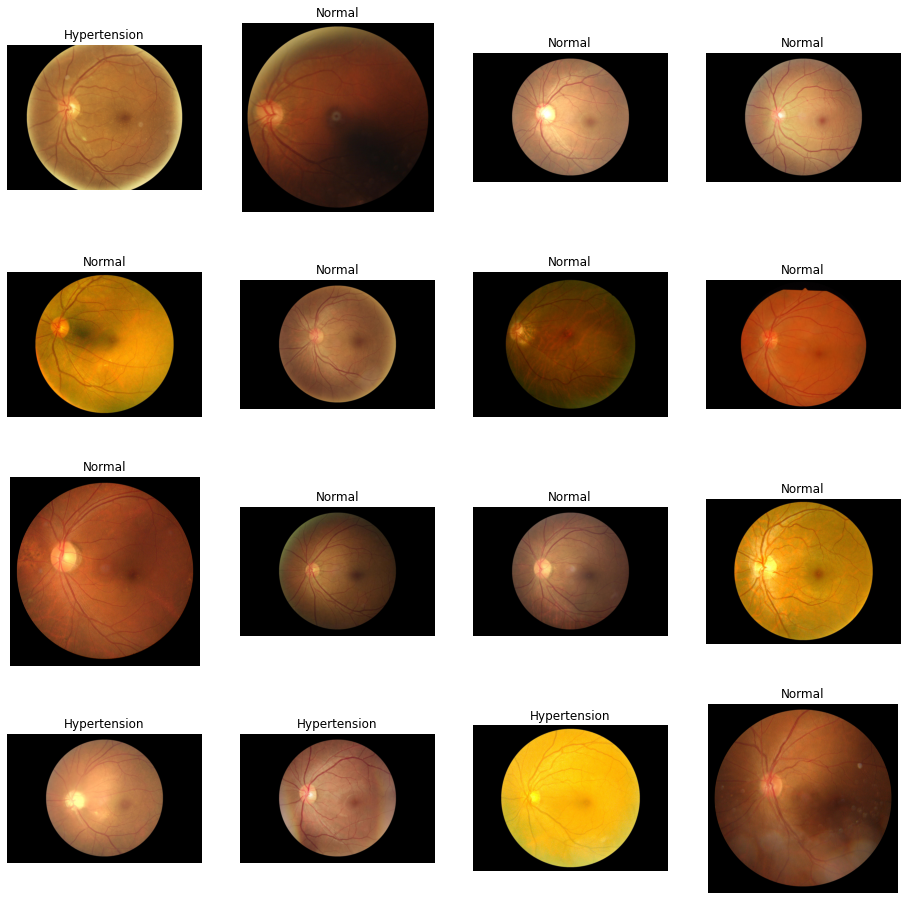

In [181]:
import os

# setup matplotlib fig, and size it to fit 4 x 4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

filename_list = df_cut.filename.tolist()

i = 0
for index_image in range(len(filename_list) - 1, 0, -1):
  # if 4 x 4 pics are already there, stop the loop
  if i == 16:
    break
  
  # setup subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # don't show axes (or gridlines)
  
  # reading and showing the image
  img = mpimg.imread(os.path.join('/content/ODIR-5K/ODIR-5K/Training Images/', filename_list[index_image]))
  plt.imshow(img)
  
  # putting title on top of the image
  title = df_cut.Labels[index_image]
  if title == 'N':
    title = 'Normal'
  elif title == 'H':
    title = 'Hypertension'
  elif title == 'C':
    title = 'Cataract'
  else:
    title = 'Pathological Myopia'
  plt.title(title)

  i += 1

plt.show()

In [182]:
# pull 80% of the combined dataset and reserve it for the training data
# the data generator will automatically create a validation set for us later
df_train = df_cut.sample(frac=0.8, random_state=42)
df_train.reset_index(drop=True)

# exclude the 80% that was already chosen, the remaining 20% will go into testing
df_test = df_cut.drop(df_train.index)
df_test.reset_index(drop=True)

print('Size of original dataset:', len(df_cut))
print('Size of train dataset:', len(df_train))
print('Size of test dataset:', len(df_test))

Size of original dataset: 953
Size of train dataset: 762
Size of test dataset: 191


In [134]:
from keras_preprocessing.image.image_data_generator import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                             vertical_flip=True,
                             horizontal_flip=True,
                             zoom_range=0.2,
                             shear_range=0.2,
                             fill_mode='nearest',
                             validation_split=0.25)

test_datagen = ImageDataGenerator(rescale=1./255)

In [135]:
train_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                              directory='/content/ODIR-5K/ODIR-5K/Training Images/',
                                              x_col='filename',
                                              y_col='Labels',
                                              class_mode='categorical',
                                              target_size=(224, 224),
                                              batch_size=8,
                                              subset='training',
                                              shuffle=True)

validation_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                              directory='/content/ODIR-5K/ODIR-5K/Training Images/',
                                              x_col='filename',
                                              y_col='Labels',
                                              class_mode='categorical',
                                              target_size=(224, 224),
                                              batch_size=16,
                                              subset='validation',
                                              shuffle=True)

test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                       directory='/content/ODIR-5K/ODIR-5K/Training Images/',
                                                       x_col='filename',
                                                       y_col='Labels',
                                                       class_mode='categorical',
                                                       target_size=(224, 224),
                                                       batch_size=16,
                                                       shuffle=True)

Found 572 validated image filenames belonging to 4 classes.
Found 190 validated image filenames belonging to 4 classes.
Found 191 validated image filenames belonging to 4 classes.


## Preparing Callbacks Needed for The Model

A few kinds of callbacks are going to be created here.

In [136]:
import tensorflow as tf
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.9 and logs.get('val_loss') < 0.4 and logs.get('val_accuracy') >= 0.85:
      print('The model has reached 90% accuracy and validation loss less than 40% and validation accuracy more than 85%')
      self.model.stop_training = True  # stopping the model training

callbacks = MyCallback()

In [58]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('eye_disease_model.h5', monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             save_freq=354)

In [150]:
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,
                                            patience=10, verbose=1)

In [151]:
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1,
                                        restore_best_weights=True)

In [152]:
my_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu')
])

## Using Transfer Learning

In this section the model is trained using pre-trained model ```MobileNetV2```. So this will be considered as transfer learning method.

In [153]:
from tensorflow.keras.applications import MobileNetV2

pre_trained_model = tf.keras.models.Sequential([
    MobileNetV2(weights='imagenet', include_top=False, input_tensor=tf.keras.layers.Input(shape=(224, 224, 3))),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

pre_trained_model.layers[0].trainable = False

In [154]:
pre_trained_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_2 (Flatten)         (None, 62720)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               32113152  
                                                                 
 dense_5 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 34,373,188
Trainable params: 32,115,204
Non-trainable params: 2,257,984
_________________________________________________________________


In [155]:
pre_trained_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
                          loss=tf.losses.CategoricalCrossentropy(),
                          metrics=['accuracy'])

In [156]:
history2 = pre_trained_model.fit(train_generator,
                                validation_data=validation_generator,
                                epochs=50,
                                callbacks=[
                                    # callbacks, 
                                    rlronp, estop],
                                verbose=1)

Epoch 1/50
72/72 [==============================] - 46s 608ms/step - loss: 1.3375 - accuracy: 0.7185 - val_loss: 0.5342 - val_accuracy: 0.8316 - lr: 1.0000e-04
Epoch 2/50
72/72 [==============================] - 42s 580ms/step - loss: 0.5253 - accuracy: 0.8304 - val_loss: 0.5439 - val_accuracy: 0.7474 - lr: 1.0000e-04
Epoch 3/50
72/72 [==============================] - 41s 578ms/step - loss: 0.3746 - accuracy: 0.8409 - val_loss: 0.6355 - val_accuracy: 0.7632 - lr: 1.0000e-04
Epoch 4/50
72/72 [==============================] - 42s 580ms/step - loss: 0.3906 - accuracy: 0.8601 - val_loss: 1.0006 - val_accuracy: 0.7474 - lr: 1.0000e-04
Epoch 5/50
72/72 [==============================] - 41s 578ms/step - loss: 0.3230 - accuracy: 0.8759 - val_loss: 0.8024 - val_accuracy: 0.8158 - lr: 1.0000e-04
Epoch 6/50
72/72 [==============================] - 41s 575ms/step - loss: 0.3258 - accuracy: 0.8706 - val_loss: 0.6060 - val_accuracy: 0.7789 - lr: 1.0000e-04
Epoch 7/50
72/72 [======================

## Evaluating the Model

The model will be evaluated by plotting both accuracies and losses of the model on every epoch.

Evaluation will also be done using unseen data.

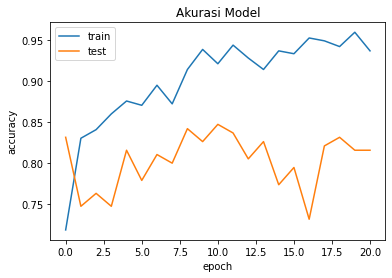

In [157]:
import matplotlib.pyplot as plt

# plotting accuracy along the epochs
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])

plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

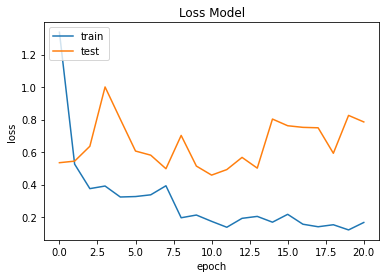

In [158]:
# plotting loss along the epochs
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [168]:
# evaluating the model using unseen data stored in test_generator variable
pre_trained_model.evaluate(test_generator)

12/12 [==============================] - 9s 749ms/step - loss: 0.4364 - accuracy: 0.8743


[0.4364120662212372, 0.8743455410003662]

## Saving the Model

Save the model in different formats that can later be loaded as needed. All kinds of format of the model created will then be copied to Google Drive.

In [159]:
import pathlib

# saving the model in SavedModel format
export_dir = 'saved_model/'
tf.saved_model.save(pre_trained_model, export_dir)
 
# Convert SavedModel to tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('model_eye_disease.tflite')
tflite_model_file.write_bytes(tflite_model)

137330912

In [160]:
# saving final model

pre_trained_model.save("model_eye_disease.h5")
tf.keras.models.save_model(pre_trained_model,'model_eye_disease.hdf5')

In [162]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [164]:
# copy it there
!cp model_eye_disease.h5 '/content/drive/MyDrive/IISMAVO/Woosong University/Introduction to Machine Learning/model_eye_disease.h5'

In [165]:
# copy it there
!cp model_eye_disease.hdf5 '/content/drive/MyDrive/IISMAVO/Woosong University/Introduction to Machine Learning/model_eye_disease.hdf5'

In [166]:
# copy it there
!cp model_eye_disease.tflite '/content/drive/MyDrive/IISMAVO/Woosong University/Introduction to Machine Learning/model_eye_disease.tflite'